# Import data libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# Read the dataset

In [2]:
fpt_dataset = pd.read_csv('FPT.csv')
msn_dataset = pd.read_csv('MSN.csv')
pnj_dataset = pd.read_csv('PNJ.csv')
vic_dataset = pd.read_csv('VIC.csv')

In [3]:
fpt_dataset.isnull().sum()

,0
Ticker,0
Date/Time,0
Open,0
High,0
Low,0
Close,0
Volume,0
Open Interest,0


In [4]:
msn_dataset.isnull().sum()

,0
Ticker,0
Date/Time,0
Open,0
High,0
Low,0
Close,0
Volume,0
Open Interest,0


In [5]:
pnj_dataset.isnull().sum()

,0
Ticker,0
Date/Time,0
Open,0
High,0
Low,0
Close,0
Volume,0
Open Interest,0


In [6]:
vic_dataset.isnull().sum()

,0
Ticker,0
Date/Time,0
Open,0
High,0
Low,0
Close,0
Volume,0
Open Interest,0


As we can see, there's no missing data in each dataset.

# Exploring the data

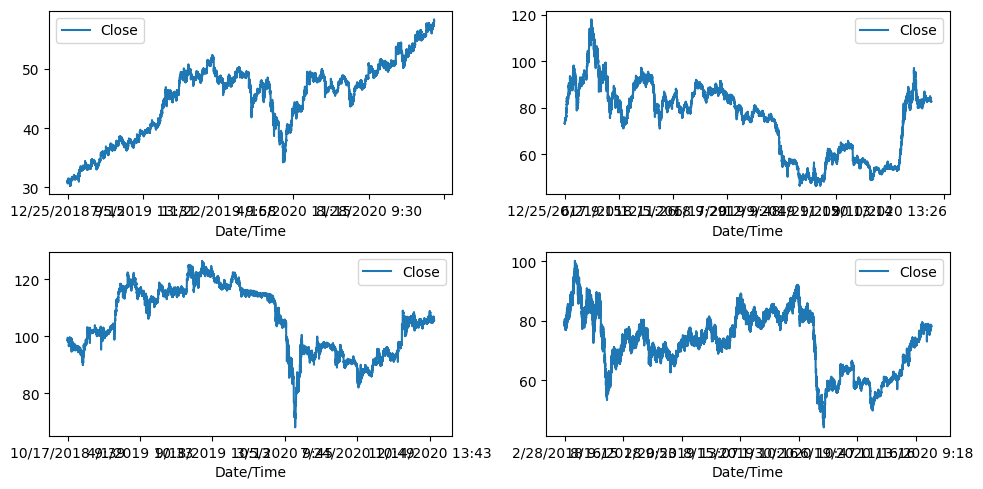

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))

fpt_dataset.plot.line(x="Date/Time", y="Close", ax=ax[0, 0])
msn_dataset.plot.line(x="Date/Time", y="Close", ax=ax[0, 1])
vic_dataset.plot.line(x="Date/Time", y="Close", ax=ax[1, 0])
pnj_dataset.plot.line(x="Date/Time", y="Close", ax=ax[1, 1])
plt.tight_layout()
plt.show()

As can be seen, the price of the stock fluctated.

# Generate the target

The target is not "does the price go up or go down", but "how much the price change". Also, we will have to use the data of the previous day to predict the price of the next day.

The following code generate the target column, which is "change" column.

In [3]:
def generate_target(dataset: pd.DataFrame):
    dataset.insert(len(dataset.columns), 'NextClose', dataset['Close'].shift(-1))
    dataset.insert(len(dataset.columns), 'Change', dataset['NextClose'] - dataset['Close'])

In [4]:
generate_target(fpt_dataset)
generate_target(msn_dataset)
generate_target(pnj_dataset)
generate_target(vic_dataset)

In [5]:
fpt_dataset.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest,NextClose,Change
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0,30.81,-0.08
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0,30.74,-0.07
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0,30.74,0.00
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0,30.74,0.00
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0,30.74,0.00


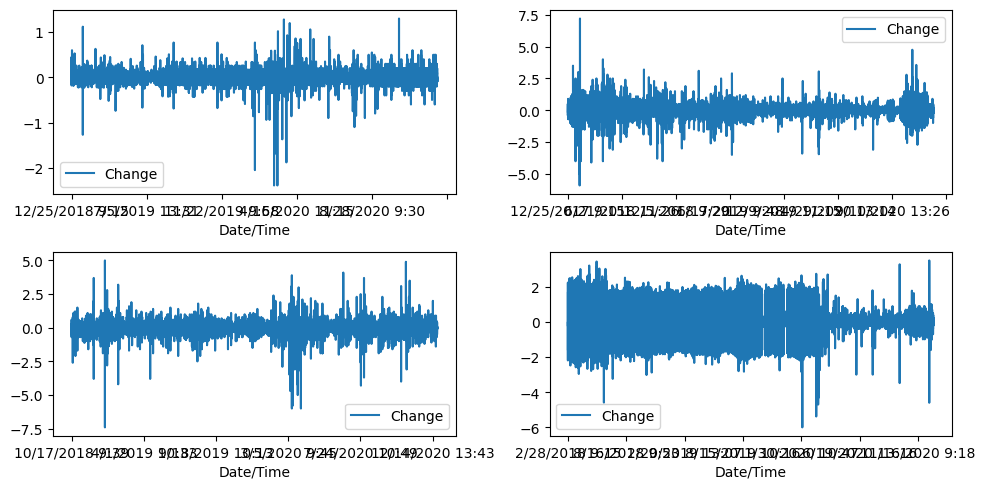

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))

fpt_dataset.plot.line(x="Date/Time", y="Change", ax=ax[0, 0])
msn_dataset.plot.line(x="Date/Time", y="Change", ax=ax[0, 1])
vic_dataset.plot.line(x="Date/Time", y="Change", ax=ax[1, 0])
pnj_dataset.plot.line(x="Date/Time", y="Change", ax=ax[1, 1])
plt.tight_layout()
plt.show()

We will not use the most recent line of the dataset (the last line) - it is not associated with any future data.

In [6]:
fpt_dataset = fpt_dataset.iloc[:-1]
msn_dataset = msn_dataset.iloc[:-1]
pnj_dataset = pnj_dataset.iloc[:-1]
vic_dataset = vic_dataset.iloc[:-1]

# Set up the metrics

Generally, the prediction of stock aims for best profit for the stock trader. So, a false positive (predict the price to increase while it actually decreases) is more harmful than a false negative (predict the price to decrease while it actually increases).

Therefore, there are two metrics to evaluate a model.

- Precision: $Precision = \dfrac{TP}{TP+FP}$.

The change determines the 'label' of the prediction: positive (increase) or negative (decrease). "No change" in the target is counted as positive, and "no change" in the prediction is counted as negative.

In [7]:
from sklearn.metrics import precision_score

def calculate_precision(y_true: pd.Series, y_pred: pd.Series):
    """
    Calculate the precision score, when both y_true and y_pred are
    regression values.

    Parameters
    ----------
    y_true : pd.Series
        The true values.
    y_pred : pd.Series
        The predicted values.

    Returns
    -------
    float
        The precision score.
    """
    y_true_label = np.select([y_true > 0, y_true < 0], [1, -1], default=1)
    y_pred_label = np.select([y_pred > 0, y_pred < 0], [1, -1], default=-1)
    return precision_score(y_true_label, y_pred_label)

- Weighted Mean Squared Error: $WMSE=\dfrac{1}{n}∑_{i=1}^{n}w_{i}(y_i-\hat{y_i})^{2}$.

Retain full penalty for false positive, and apply lesser penalty for false negative (0.8). If true postive or true negative, the weight is much lesser (0.5).

In [8]:
from sklearn.metrics import mean_squared_error

def calculate_weighted_mse(y_true: pd.Series, y_pred: pd.Series):
    """
    Calculate the weighted mean squared error, when both y_true and y_pred are
    regression values.

    Parameters
    ----------
    y_true : pd.Series
        The true values.
    y_pred : pd.Series
        The predicted values.

    Returns
    -------
    float
        The precision score.
    """
    y_true_label = np.select([y_true > 0, y_true < 0], [1, -1], default=1)
    y_pred_label = np.select([y_pred > 0, y_pred < 0], [1, -1], default=-1)
    weights = np.select([y_true_label == y_pred_label,
                         y_true_label == -1,
                         y_true_label == 1], [0.5, 0.8, 1.0], default=1.0)
    return mean_squared_error(y_true, y_pred, sample_weight=weights)

# Test machine learning models

Because the dataset is time-series, we cannot use cross-validation for the entire dataset. This will cause feature leakage where the data of the future is used to predict past price change.

In this section we use only the FPT dataset for experimenting purpose in training.

In [15]:
from sklearn.preprocessing import MinMaxScaler

fpt_scaler = MinMaxScaler((-1, 1))
fpt_scaler_target = MinMaxScaler((-1, 1))

training_dataset = fpt_dataset.drop(columns=['Ticker', 'Date/Time', 'NextClose'])
training_dataset = pd.DataFrame(fpt_scaler.fit_transform(training_dataset), columns=training_dataset.columns)
X = training_dataset.drop(columns=['Change'])
y = fpt_scaler_target.fit_transform(fpt_dataset[['Change']]).reshape(-1)

Train a few machine learning regression models.

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    SVR()
]

num_train_samples = math.ceil(len(X) * 0.8)

X_train = X[:num_train_samples]
y_train = y[:num_train_samples]
X_test = X[num_train_samples:]
y_test = y[num_train_samples:]

model_results = []

for model in tqdm(models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    model_results.append({
        'model': model.__class__.__name__,
        'prediction': fpt_scaler_target.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1),
        'precision': calculate_precision(y_test, y_pred),
        'weighted_mse': calculate_weighted_mse(y_test, y_pred)
    })

100%|██████████| 4/4 [01:15<00:00, 18.80s/it]


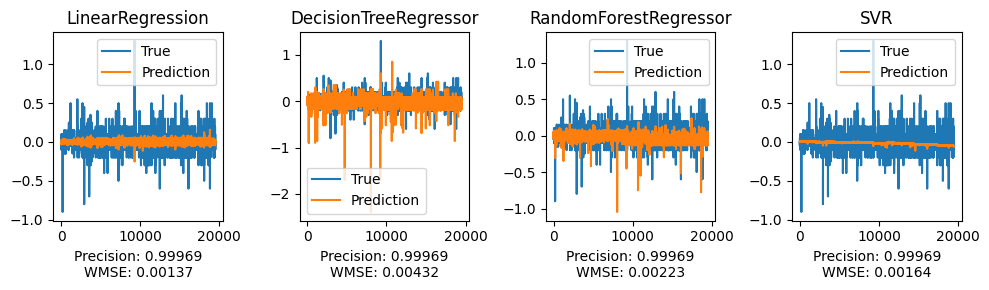

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(10, 3))

for i, model_result in enumerate(model_results):
    ax[i].plot(fpt_dataset['Change'][num_train_samples:].to_list(), label='True')
    ax[i].plot(model_result['prediction'], label='Prediction')
    ax[i].set_title(model_result['model'])
    ax[i].legend()
    ax[i].set_xlabel(f'Precision: {model_result["precision"]:.5f}\n' +
                     f'WMSE: {model_result["weighted_mse"]:.5f}')

plt.tight_layout()
plt.show()

Testing on MSN dataset.

In [18]:
msn_scaler = MinMaxScaler((-1, 1))
msn_scaler_target = MinMaxScaler((-1, 1))

test_dataset = msn_dataset.drop(columns=['Ticker', 'Date/Time', 'NextClose', 'Change'])
test_dataset = pd.DataFrame(msn_scaler.fit_transform(test_dataset), columns=test_dataset.columns)
X_test = test_dataset
y_test = msn_scaler_target.fit_transform(msn_dataset[['Change']]).reshape(-1)

new_model_results = []

for model in tqdm(models):
    y_pred = model.predict(X_test)

    new_model_results.append({
        'model': model.__class__.__name__,
        'prediction': msn_scaler_target.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1),
        'precision': calculate_precision(y_test, y_pred),
        'weighted_mse': calculate_weighted_mse(y_test, y_pred)
    })

100%|██████████| 4/4 [00:07<00:00,  1.97s/it]


In [19]:
models[0].predict(X_test)

array([0.30031559, 0.30026787, 0.30050263, ..., 0.30111144, 0.30527276,
       0.30527389])

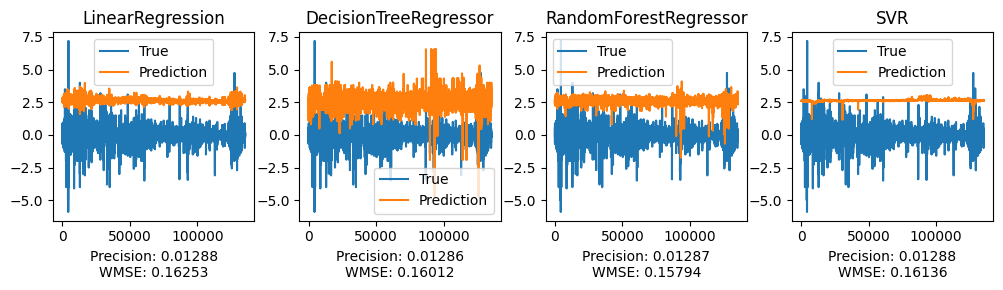

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(10, 3))

for i, new_model_result in enumerate(new_model_results):
    ax[i].plot(msn_dataset['Change'].to_list(), label='True')
    ax[i].plot(new_model_result['prediction'], label='Prediction')
    ax[i].set_title(new_model_result['model'])
    ax[i].legend()
    ax[i].set_xlabel(f'Precision: {new_model_result["precision"]:.5f}\n' +
                    f'WMSE: {new_model_result["weighted_mse"]:.5f}')

plt.tight_layout()
plt.show()

From this result, it can be concluded that the model does not perform well in unseen data.

# LSTM models

LSTM (Long-Short Term Memory) is a Recurrent Neural Network where each output becomes the input of the next output. Therefore, this model is suitable for time-series tasks such as predicting the stock change.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, LSTM, Dropout

In [32]:
lstm_model = Sequential()
lstm_model.add(InputLayer(shape=(100,6)))
lstm_model.add(LSTM(units=50, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=60, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=80, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=120))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In this section we use only the FPT dataset for experimenting purpose in training, using scaled data.

In [33]:
fpt_scaler = MinMaxScaler((-1, 1))
fpt_scaler_target = MinMaxScaler((-1, 1))

training_dataset_lstm = fpt_dataset.drop(columns=['Ticker', 'Date/Time', 'NextClose'])
training_dataset_lstm = pd.DataFrame(fpt_scaler.fit_transform(training_dataset_lstm), columns=training_dataset_lstm.columns)
X_train_lstm = training_dataset_lstm.drop(columns=['Change'])
y_train_lstm = fpt_scaler_target.fit_transform(fpt_dataset[['Change']]).reshape(-1)

X_train_lstm_batch = []
y_train_lstm_batch = []

BATCH_TIMESTEPS = 1000

for i in tqdm(range(BATCH_TIMESTEPS, len(X_train_lstm))):
    X_train_lstm_batch.append(X_train_lstm.iloc[i-BATCH_TIMESTEPS:i].to_numpy())
    y_train_lstm_batch.append(y_train_lstm[i])

100%|██████████| 96405/96405 [00:01<00:00, 53502.29it/s]


In [34]:
num_train_samples = math.ceil(len(X_train_lstm_batch) * 0.8)

lstm_model.fit(np.array(X_train_lstm_batch[:num_train_samples]),
               np.array(y_train_lstm_batch[:num_train_samples]), epochs=10)

Epoch 1/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 285s 117ms/step - loss: 0.0019 - mean_absolute_error: 0.0286
Epoch 2/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 319s 115ms/step - loss: 0.0013 - mean_absolute_error: 0.0215
Epoch 3/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 324s 116ms/step - loss: 0.0011 - mean_absolute_error: 0.0195
Epoch 4/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 321s 116ms/step - loss: 0.0011 - mean_absolute_error: 0.0189
Epoch 5/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 321s 116ms/step - loss: 0.0011 - mean_absolute_error: 0.0183
Epoch 6/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 322s 116ms/step - loss: 0.0012 - mean_absolute_error: 0.0182
Epoch 7/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 320s 115ms/step - loss: 0.0011 - mean_absolute_error: 0.0179
Epoch 8/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 322s 115ms/step - loss: 0.0011 - mean_absolute_error: 0.0181
Epoch 9/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 323s 116ms/step - loss: 0.0011 - mean_absolute_error: 0.0180
Epoch 10/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 321s 115ms/step - loss: 0.0011

In [35]:
y_pred = lstm_model.predict(np.array(X_train_lstm_batch[num_train_samples:]))

603/603 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step


In [36]:
calculate_precision(np.array(y_train_lstm_batch[num_train_samples:]).reshape(-1, 1),
                    y_pred)

0.9997406773507598

In [37]:
calculate_weighted_mse(np.array(y_train_lstm_batch[num_train_samples:]).reshape(-1, 1),
                       y_pred)

0.0014818915258600878

In [38]:
num_test_samples = np.array(y_train_lstm_batch[num_train_samples:]).shape[0]
true_prediction = fpt_scaler_target.inverse_transform(np.array(y_pred).reshape(-1, 1)).reshape(-1)

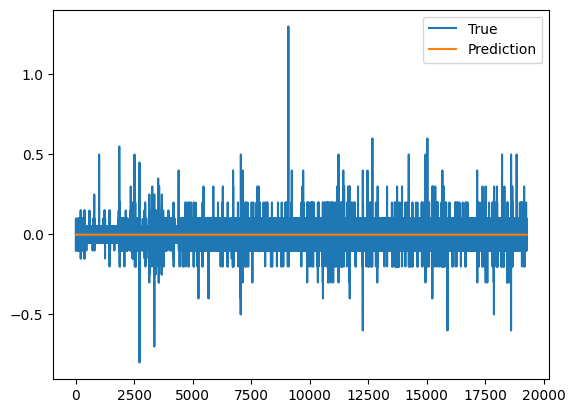

In [39]:
plt.plot(fpt_dataset['Change'][-num_test_samples:].to_list(), label='True')
plt.plot(true_prediction, label='Prediction')
plt.legend()
plt.show()

It does not perform well in scaled data. Let's consider unscaled data instead.

In [8]:
lstm_model_unscaled = Sequential()
lstm_model_unscaled.add(InputLayer(shape=(100,6)))
lstm_model_unscaled.add(LSTM(units=50, return_sequences=True))
lstm_model_unscaled.add(Dropout(0.2))
lstm_model_unscaled.add(LSTM(units=60, return_sequences=True))
lstm_model_unscaled.add(Dropout(0.2))
lstm_model_unscaled.add(LSTM(units=80, return_sequences=True))
lstm_model_unscaled.add(Dropout(0.2))
lstm_model_unscaled.add(LSTM(units=120))
lstm_model_unscaled.add(Dropout(0.2))
lstm_model_unscaled.add(Dense(units=1))

In [9]:
training_dataset_lstm = fpt_dataset.drop(columns=['Ticker', 'Date/Time', 'NextClose'])
X_train_lstm = training_dataset_lstm.drop(columns=['Change'])
y_train_lstm = fpt_dataset['Change']

X_train_lstm_batch = []
y_train_lstm_batch = []

BATCH_TIMESTEPS = 1000

for i in tqdm(range(BATCH_TIMESTEPS, len(X_train_lstm))):
    X_train_lstm_batch.append(X_train_lstm.iloc[i-BATCH_TIMESTEPS:i].to_numpy())
    y_train_lstm_batch.append(y_train_lstm[i])

100%|██████████| 96405/96405 [00:09<00:00, 9830.22it/s] 


In [10]:
lstm_model_unscaled.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [ ]:
num_train_samples = math.ceil(len(X_train_lstm_batch) * 0.8)
lstm_model_unscaled.fit(np.array(X_train_lstm_batch[:num_train_samples]),
               np.array(y_train_lstm_batch[:num_train_samples]), epochs=10)